# Understanding World Series Champions
_Ravi Dayabhai_

![World Series pageantry](http://a.espncdn.com/media/motion/2013/1024/dm_131024_mlb_olbermann_why_nobody_watches_world_series/dm_131024_mlb_olbermann_why_nobody_watches_world_series.jpg)

## Part I: Characterizing World Series Champions

To begin, I ask a simple question: **What do various "profiles" of World Series winning teams throughout history look like?** Are these teams powerhouse on both sides of the ball? Or, for example, do many enjoy success as a result of being the absolute best in one particular phase of the game (e.g., 1995 Atlanta Braves pitching)?

In [195]:
# Import all the modules used in the subsequent analysis

import glob
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

## Show all the columns ##
pd.set_option('display.max_columns', None)
## Show limited rows ##
pd.set_option('display.max_rows', 100)

## Ignore RuntimeWarning: invalid value when computing percentiles ##
np.seterr(divide='ignore', invalid='ignore')

### 0. Import data into a dictionary of dataframes ###
filename_list = glob.glob('*.csv')
data_dict = {f[:-4]: pd.read_csv(f) for f in filename_list}

To answer this question, we begin our data adventure by importing not only all of the modules needed for this project, but the data set itself! I chose to store all of the data as Pandas DataFrames, all of which were then stored as values in a dictionary. The dictionary (`data_dict`) keys are the original file names of the \*.CSVs.

### Data Wrangling

I began by adding a few more composite metrics such as WHIP (`WHIP`) and slugging percentage (`SLG`) to beef up the existing data. It can be argued that these added metrics do a better job capturing a given teams defensive, offensive, or pitching prowess. Unfortunately, as will be seen later, some statistics (e.g., sacrifice flies) did not span the entire history of baseball and resulted in `NaN`s for these composite metrics for relatively earlier dated data (e.g., years before 2000).

In [196]:
### 1. Rankings of WS-winning Teams ###

## 1.1 Adding compound team metrics ##

# On-base Percentage, "OBP"
data_dict["Teams"]["OBP"] = (data_dict[
    "Teams"]["H"] + data_dict[
        "Teams"]["BB"] + data_dict[
            "Teams"]["HBP"]) / (data_dict[
                "Teams"]["AB"] + data_dict[
                    "Teams"]["SF"] + data_dict[
                        "Teams"]["BB"] + data_dict[
                            "Teams"]["HBP"])

# Slugging Percentage, "SLG"
TB_weights = pd.DataFrame([1, 2, 3, 4], index=['S', '2B', '3B', 'HR'])
data_dict["Teams"]["S"] = data_dict["Teams"][
    "H"] - data_dict["Teams"].ix[:, "2B": "HR"].sum(axis=1)

new_col_list = ['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', 'S', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS',
                'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro', 'OBP']

data_dict["Teams"] = data_dict["Teams"][new_col_list]

data_dict["Teams"]["TB"] = data_dict["Teams"].ix[:, "S":"HR"].dot(TB_weights)

data_dict["Teams"]["SLG"] = data_dict["Teams"]["TB"] / data_dict[
    "Teams"]["AB"]

# On-base plus slugging, "OPS"
data_dict["Teams"]["OPS"] = data_dict[
    "Teams"]["OBP"] + data_dict["Teams"]["SLG"]

# Team Batting Average, "teamBA"
data_dict["Teams"]["teamBA"] = data_dict[
    "Teams"]["H"] / data_dict["Teams"]["AB"]

# Walks plus hits per inning pitched, "WHIP"

data_dict["Teams"]["WHIP"] = (data_dict["Teams"][
                              "BBA"] + data_dict["Teams"]["HA"]) / (data_dict["Teams"]["IPouts"] / 3)

# Making WSWin column summarizable by assigning integer values to status
data_dict["Teams"].replace({'WSWin': {'Y': 1, 'N': 0}}, inplace=True)

In [197]:
data_dict["Teams"]

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,S,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,OBP,TB,SLG,OPS,teamBA,WHIP
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,NaN,NaN,N,NaN,401,1372,426,316,70,37,3,60,19.0,73.0,NaN,NaN,NaN,303,109,3.55,22,1,3,828,367,2,42,23,225,NaN,0.838,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1,NaN,579,0.422012,NaN,0.310496,1.481884
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,NaN,NaN,N,NaN,302,1196,323,240,52,21,10,60,22.0,69.0,NaN,NaN,NaN,241,77,2.76,25,0,1,753,308,6,28,22,218,NaN,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1,NaN,447,0.373746,NaN,0.270067,1.338645
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,NaN,NaN,N,NaN,249,1186,328,246,35,40,7,26,25.0,18.0,NaN,NaN,NaN,341,116,4.11,23,0,0,762,346,13,53,34,223,NaN,0.814,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1,NaN,464,0.391231,NaN,0.276560,1.570866
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,NaN,NaN,N,NaN,137,746,178,149,19,8,2,33,9.0,16.0,NaN,NaN,NaN,243,97,5.17,19,1,0,507,261,5,21,17,163,NaN,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1,NaN,219,0.293566,NaN,0.238606,1.668639
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,NaN,NaN,N,NaN,302,1404,403,338,43,21,1,33,15.0,46.0,NaN,NaN,NaN,313,121,3.72,32,1,0,879,373,7,42,22,227,NaN,0.839,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2,NaN,491,0.349715,NaN,0.287037,1.416382
5,1871,NaN,PH1,PNA,NaN,1,28,NaN,21,7,NaN,NaN,Y,NaN,376,1281,410,308,66,27,9,46,23.0,56.0,NaN,NaN,NaN,266,137,4.95,27,0,0,747,329,3,53,16,194,NaN,0.845,Philadelphia Athletics,Jefferson Street Grounds,NaN,102,98,ATH,PH1,PH1,NaN,557,0.434817,NaN,0.320062,1.534137
6,1871,NaN,RC1,ROK,NaN,9,25,NaN,4,21,NaN,NaN,N,NaN,231,1036,274,202,44,25,3,38,30.0,53.0,NaN,NaN,NaN,287,108,4.30,23,1,0,678,315,3,34,16,220,NaN,0.821,Rockford Forest Citys,Agricultural Society Fair Grounds,NaN,97,99,ROK,RC1,RC1,NaN,377,0.363900,NaN,0.264479,1.544248
7,1871,NaN,TRO,TRO,NaN,6,29,NaN,13,15,NaN,NaN,N,NaN,351,1248,384,293,51,34,6,49,19.0,62.0,NaN,NaN,NaN,362,153,5.51,28,0,0,750,431,4,75,12,198,NaN,0.845,Troy Haymakers,Haymakers' Grounds,NaN,101,100,TRO,TRO,TRO,NaN,521,0.417468,NaN,0.307692,2.024000
8,1871,NaN,WS3,OLY,NaN,4,32,NaN,15,15,NaN,NaN,N,NaN,310,1353,375,289,54,26,6,48,13.0,48.0,NaN,NaN,NaN,303,137,4.37,32,0,0,846,371,4,45,13,217,NaN,0.850,Washington Olympics,Olympics Grounds,NaN,94,98,OLY,WS3,WS3,NaN,499,0.368810,NaN,0.277162,1.475177
9,1872,NaN,BL1,BLC,NaN,2,58,NaN,35,19,NaN,NaN,N,NaN,617,2576,747,604,94,35,14,27,28.0,35.0,15.0,NaN,NaN,434,173,3.02,48,1,1,1545,566,3,63,0,432,NaN,0.829,Baltimore Canaries,Newington Park,NaN,106,102,BAL,BL1,BL1,NaN,953,0.369953,NaN,0.289984,1.221359


In [198]:
# Select only the World Series Champions
wswinners = data_dict["Teams"][data_dict["Teams"]["WSWin"] == 1].groupby(["yearID","teamID"]).mean()
wswinners

,,Rank,G,Ghome,W,L,WSWin,R,AB,H,S,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF,OBP,TB,SLG,OPS,teamBA,WHIP
yearID,teamID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1884,PRO,1,114,NaN,84,28,1.0,665,4093,987,770,153,43,21,300,469.0,NaN,NaN,NaN,NaN,388,185,1.61,107,16,2,3108,825,26,172,639,398,NaN,0.918,NaN,99,96,NaN,1289,0.314928,NaN,0.241143,0.962355
1886,SL4,1,139,NaN,93,46,1.0,944,5009,1365,1054,206,85,20,400,425.0,336.0,NaN,NaN,NaN,592,340,2.49,134,14,2,3687,1087,13,329,583,494,NaN,0.915,NaN,105,100,NaN,1801,0.359553,NaN,0.272509,1.152156
1887,DTN,1,127,NaN,79,45,1.0,969,4689,1404,1010,213,126,55,352,258.0,267.0,NaN,NaN,NaN,714,490,3.95,122,3,1,3348,1172,52,344,337,384,NaN,0.926,NaN,104,100,NaN,2034,0.433781,NaN,0.299424,1.358423
1888,NY1,1,138,NaN,84,47,1.0,659,4747,1149,888,130,76,55,270,456.0,314.0,NaN,NaN,NaN,479,263,1.96,133,20,1,3624,907,27,307,726,430,NaN,0.924,NaN,99,96,NaN,1596,0.336212,NaN,0.242048,1.004967
1889,NY1,1,131,NaN,83,43,1.0,935,4671,1319,982,208,77,52,538,386.0,292.0,NaN,NaN,NaN,708,444,3.47,118,6,3,3453,1073,38,523,558,436,NaN,0.920,NaN,104,101,NaN,1837,0.393278,NaN,0.282381,1.386620
1903,BOS,1,141,70.0,91,47,1.0,708,4919,1336,953,222,113,48,262,561.0,141.0,NaN,NaN,NaN,504,358,2.57,123,20,4,3765,1142,23,269,579,235,86.0,0.959,379338.0,105,102,NaN,1928,0.391950,NaN,0.271600,1.124303
1905,NY1,1,155,76.0,105,48,1.0,780,5094,1392,1074,191,88,39,517,NaN,291.0,NaN,NaN,NaN,505,364,2.39,117,18,15,4110,1160,25,364,760,253,93.0,0.960,552700.0,102,98,NaN,1876,0.368276,NaN,0.273263,1.112409
1906,CHA,1,154,79.0,93,58,1.0,570,4925,1133,922,152,52,7,453,NaN,214.0,NaN,NaN,NaN,460,325,2.13,117,32,3,4125,1212,11,255,543,243,80.0,0.963,585202.0,98,95,NaN,1410,0.286294,NaN,0.230051,1.066909
1907,CHN,1,155,76.0,107,45,1.0,574,4892,1224,1001,162,48,13,435,NaN,235.0,NaN,NaN,NaN,390,264,1.73,114,32,8,4119,1054,11,402,586,211,110.0,0.967,422550.0,106,101,NaN,1521,0.310916,NaN,0.250204,1.060452


The first order of business was to aggregate all of the players throughout the entirety of the data set by year and team (ultimately, to compute team-level metrics which were not already provided in the `Teams` table). I merged the `Batting`, `Pitching`, and `Fielding` tables to achieve this. More work was required to wrangle the data such that I could add `age` and `salary` (averages for each team) to the `Teams` table.

In [199]:
## Computing average age of teams per year ##

# Create dataframe of all players on each team in each year; player might
# show up on 2+ different teams in a given year
tables_of_players = ["Batting", "Pitching", "Fielding"]
tables_to_merge = []
for table in tables_of_players:
    df = data_dict[table]
    tables_to_merge.append(df.groupby(
        ["yearID", "teamID", "playerID"]).mean())

all_players_byteam = reduce(lambda left, right: pd.merge(
    left, right, left_index=True, right_index=True, how="outer"), tables_to_merge)

all_players_byteam.reset_index(inplace=True)
all_players_byteam = all_players_byteam[["yearID", "teamID", "playerID"]]
player_info = data_dict["Master"]
age_df = all_players_byteam.merge(
    player_info[["playerID", "birthYear"]], on="playerID")
age_df["age"] = age_df["yearID"] - age_df["birthYear"]

I also double-checked the comprehensiveness of the data along the `age` and `salary` dimensons. Given the quantity of data, I don't expect these (relatively few) missing values to bias our analysis.

In [200]:
# Players with missing 'birthYear's == 130
missing_age_info = age_df[age_df.isnull().birthYear]
print len(set(missing_age_info.playerID))

130


In [201]:
# Add "age", "salaries" column to "Teams" table
grouped_Ages = age_df.groupby(["yearID", "teamID"]).mean()[["age"]]
grouped_Teams = data_dict["Teams"].groupby(["yearID", "teamID"]).mean()
salary_info = data_dict["Salaries"].groupby(
    ["yearID", "teamID"]).median()[["salary"]]

team_summary_per_year = grouped_Teams.join(
    grouped_Ages, how="left").join(salary_info, how="left")

team_summary_per_year

Rank    G  Ghome    W    L  WSWin    R    AB     H     S   2B  \
yearID teamID                                                                  
1871   BS1        3   31    NaN   20   10    NaN  401  1372   426   316   70   
       CH1        2   28    NaN   19    9    NaN  302  1196   323   240   52   
       CL1        8   29    NaN   10   19    NaN  249  1186   328   246   35   
       FW1        7   19    NaN    7   12    NaN  137   746   178   149   19   
       NY2        5   33    NaN   16   17    NaN  302  1404   403   338   43   
       PH1        1   28    NaN   21    7    NaN  376  1281   410   308   66   
       RC1        9   25    NaN    4   21    NaN  231  1036   274   202   44   
       TRO        6   29    NaN   13   15    NaN  351  1248   384   293   51   
       WS3        4   32    NaN   15   15    NaN  310  1353   375   289   54   
1872   BL1        2   58    NaN   35   19    NaN  617  2576   747   604   94   
       BR1        9   29    NaN    3   26    NaN  152  1075   235   203   26   
       BR2        6   37    NaN    9   28    NaN  237  1466   370   314   46   
       BS1        1   48    NaN   39    8    NaN  521  2137   677   525  114   
       CL1        7   22    NaN    6   16    NaN  174   935   272   229   37   
       MID        8   24    NaN    5   19    NaN  220  1014   305   265   31   
       NY2        3   56    NaN   34   20    NaN  523  2423   668   565   86   
       PH1        4   47    NaN   30   14    NaN  539  2140   678   574   77   
       TRO        5   25    NaN   15   10    NaN  273  1124   329   257   56   
       WS3       10    9    NaN    2    7    NaN   54   363    93    78   12   
       WS4       11   11    NaN    0   11    NaN   80   460   105   100    3   
1873   BL1        3   57    NaN   34   22    NaN  644  2563   810   640  119   
       BL4        9    6    NaN    0    6    NaN   26   211    33    28    5   
       BR2        6   55    NaN   17   37    NaN  366  2210   588   495   60   
       BS1        1   60    NaN   43   16    NaN  739  2755   930   734  137   
       ELI        8   23    NaN    2   21    NaN   98   868   204   175   21   
       NY2        4   53    NaN   29   24    NaN  424  2214   622   509   67   
       PH1        5   52    NaN   28   23    NaN  474  2266   683   581   76   
       PH2        2   53    NaN   36   17    NaN  526  2325   645   534   83   
       WS5        7   39    NaN    8   31    NaN  283  1563   408   335   45   
1874   BL1        8   47    NaN    9   38    NaN  227  1781   435   373   53   
       BR2        6   56    NaN   22   33    NaN  301  2165   497   435   50   
       BS1        1   71    NaN   52   18    NaN  735  3122   981   776  130   
       CH2        5   59    NaN   28   31    NaN  418  2457   690   595   89   
       HR1        7   53    NaN   16   37    NaN  371  2140   587   474   92   
       NY2        2   65    NaN   42   23    NaN  500  2719   709   570  100   
       PH1        3   55    NaN   33   22    NaN  441  2260   646   536   87   
       PH2        4   58    NaN   29   29    NaN  476  2432   690   562   74   
1875   BR2       11   44    NaN    2   42    NaN  132  1547   304   261   32   
       BS1        1   82    NaN   71    8    NaN  831  3516  1124   899  157   
       CH2        6   69    NaN   30   37    NaN  379  2658   697   599   85   
       HR1        3   86    NaN   54   28    NaN  557  3342   873   739   98   
       KEO       13   13    NaN    1   12    NaN   45   449    81    66    9   
       NH1        8   47    NaN    7   40    NaN  170  1708   374   318   42   
       NY2        6   71    NaN   30   38    NaN  328  2683   626   511   84   
       PH1        2   77    NaN   53   20    NaN  699  3245   940   743  126   
       PH2        5   70    NaN   37   31    NaN  470  2717   681   583   65   
       PH3       11   14    NaN    2   12    NaN   70   529   126   104   19   
       SL1       10   19    NaN    4   15    NaN   60   688   138   117   20   
       SL2     

I noticed that the join seemed to raise a handful of `NaN`s for select teams in 2016 (note: the only available salary data starts with 1985). I proceeded to fix the join for the most recent season by finding the teams where the merged failed.

In [202]:
# Find the rows in the team_summary_per_year table missing salary info
missing_team_sals = list(zip(*team_summary_per_year[team_summary_per_year.salary.isnull()].salary.ix[1985:].index.values))

In [203]:
## Fixing year 2016's missing salary summary stats due to mismatched teamIDs ##

missing_team_sals

[(2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016),
 ('CHA', 'CHN', 'KCA', 'LAN', 'NYA', 'NYN', 'SDN', 'SFN', 'SLN', 'TBA', 'WAS')]

This error was caused by a mismatch between `teamID` (used by the `Teams` table) and `teamIDBR` (from _
Baseball Reference_, as per the data set). The following code confirmed that these IDs did not match.

In [204]:
# Find the teamIDs in salary_info but NOT in team_summary_per_year
teamIDs_from_salary_info = list(set(salary_info.ix[2016].index.values) - set(team_summary_per_year.ix[2016].index.values))

teamIDs_from_salary_info

['CHC', 'SDP', 'TBR', 'STL', 'CHW', 'KCR', 'WSN', 'LAD', 'NYY', 'NYM', 'SFG']

A decently simple solution was implemented below. I began by creating a "look-up" table for the `teamID`s.

In [205]:
# Reconcile teamIDs; create a mapping to do look-up
teamID_df = data_dict["Teams"][data_dict["Teams"].loc[
    :, "yearID"] == 2016].loc[:, ["teamIDBR", "teamID"]]

teamID_mapping = teamID_df[teamID_df["teamID"] !=
                           teamID_df["teamIDBR"]]

teamID_mapping.set_index(["teamID"], drop=True, inplace=True)

teamID_mapping

,teamIDBR
teamID,
CHA,CHW
CHN,CHC
KCA,KCR
LAN,LAD
NYA,NYY
NYN,NYM
SDN,SDP
SFN,SFG
SLN,STL


Using the look up table, I extracted the correct values from the `salary_info` table and replaced the `NaN`s with these values in the `team_summary_per_year` table.

In [206]:
# Replace the missing 'salary' values in team_summary_per_year"

# Ignore SettingWithCopyWarning flag
pd.options.mode.chained_assignment = None

mask = team_summary_per_year.loc[2016, 'salary'].isnull()

df = team_summary_per_year.loc[2016,
                               'salary'].loc[mask]

df1 = df.reset_index()['teamID'].map(
    lambda x: salary_info.loc[(2016, teamID_mapping.loc[x, 'teamIDBR']), 'salary'])

team_summary_per_year.loc[2016,
                          'salary'].loc[mask] = df1.astype(np.float64).values

team_summary_per_year.loc[2016].loc[:,["salary"]]

,salary
teamID,
ARI,1387500.0
ATL,1000000.0
BAL,2800000.0
BOS,1250000.0
CHA,2750000.0
CHN,2500000.0
CIN,530000.0
CLE,2000000.0
COL,1300000.0


The next step in the analysis required normalizing the data. Two normalization methods that came to mind were calculating (1) the percentile rank for each year's World Series winning team relative to its peers and (2) the number of standard deviations away from the mean (i.e., a z-score) the World Series winning team was. 

In [207]:
### 1.2 Assemble dataframe of rankings for selected statistics ###

# Begin exploring where the WS team falls in distribution for various
# statistics vs. competitors in a given year ###

## Ignore RuntimeWarning: invalid value when computing percentiles ##
np.seterr(divide='ignore', invalid='ignore')

def pctile_calc(x):
    return [stats.percentileofscore(x, a, 'mean') for a in x]


def zscore(x):
    return stats.zscore(x)


def stdizer(df, names, *args):
    std_tables = {}
    name_picker = 0
    for f in args:
        temp_dic = {}
        for year in set(team_summary_per_year.index.get_level_values("yearID")):
            df_temp = df.loc[year].apply(f)
            df_temp["yearID"] = [year for teams in df_temp.index.values]
            temp_dic[year] = df_temp.reset_index().groupby(
                ["yearID", "teamID"]).max()
        std_tables[names[name_picker]] = pd.concat(list(temp_dic.values()))
        name_picker += 1
    return std_tables


std_tables_names = ["percentiles", "zscores"]
std_data_library = stdizer(team_summary_per_year,
                           std_tables_names, pctile_calc, zscore)

# Select z-score data just for WS winners
df = std_data_library["zscores"].reset_index()
i1 = df.set_index(["yearID","teamID"]).index
i2 = wswinners.reset_index().set_index(["yearID","teamID"]).index
zscores_wswinners = df[i1.isin(i2)].set_index(["yearID","teamID"])

zscores_wswinners

,,Rank,G,Ghome,W,L,WSWin,R,AB,H,S,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF,OBP,TB,SLG,OPS,teamBA,WHIP,age,salary
yearID,teamID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1884,PRO,-1.497976,0.617808,NaN,1.507357,-0.885876,NaN,0.686920,0.649262,0.564296,0.633778,0.591091,-0.135611,0.003712,2.160735,0.159088,NaN,NaN,NaN,NaN,-0.628344,-0.897761,-2.031035,0.620075,2.432067,1.312395,0.750393,0.067939,0.331077,0.301906,1.010132,-0.257647,NaN,1.631244,NaN,0.160200,-0.204338,NaN,0.455868,-0.056342,NaN,0.144491,-1.154513,0.551774,NaN
1886,SL4,-1.527525,0.924940,NaN,1.503075,-0.969087,3.872983,1.527061,1.339719,1.706426,1.803084,1.373627,0.776654,-0.455407,0.672457,-1.531576,2.114915,NaN,NaN,NaN,-0.921301,-0.930423,-1.253323,0.958849,2.097775,1.336198,1.083378,-0.315299,-1.341992,-0.260422,0.193802,0.003108,NaN,0.460603,NaN,0.769489,-0.276501,NaN,1.414598,0.779859,NaN,1.162734,-1.198199,0.072712,NaN
1887,DTN,-1.527525,-0.949653,NaN,0.915086,-1.222839,3.872983,0.927405,0.079243,1.085741,0.632276,0.749861,2.491368,1.060043,-0.454766,-2.278774,-1.326086,NaN,NaN,NaN,-0.989209,-0.559648,-0.381658,-0.750405,-0.664269,-0.069505,-0.735781,-0.830089,1.072790,-0.503939,-0.373170,-1.886957,NaN,1.911691,NaN,0.657162,-0.058421,NaN,1.612535,1.961846,NaN,1.612417,-0.560218,1.084329,NaN
1888,NY1,-1.527525,0.577350,NaN,1.105571,-1.310916,3.872983,-0.055279,0.272964,0.278790,0.256827,-1.003161,0.583005,1.244377,-0.521199,-1.001593,-0.200329,NaN,NaN,NaN,-1.462153,-1.548073,-1.475986,0.457622,2.306446,0.506502,0.146862,-1.958191,-0.366286,0.175249,2.283387,-0.820919,NaN,0.755956,NaN,-0.453400,-1.138055,NaN,0.555118,0.574281,NaN,0.258839,-1.276602,1.420128,NaN
1889,NY1,-1.527525,-1.266348,NaN,0.985184,-1.353113,3.872983,1.134193,-0.774473,0.993561,0.606891,0.674621,0.620193,0.627059,1.290710,-1.294031,-0.115132,NaN,NaN,NaN,-0.844359,-1.079543,-0.836989,-0.342823,0.097184,0.404520,-0.965287,-1.746970,-0.292931,1.239835,1.025854,-0.447677,NaN,0.073258,NaN,0.449461,-0.047088,NaN,1.043211,1.626682,NaN,1.975398,-0.567822,2.142176,NaN
1903,BOS,-1.527525,1.093216,0.106668,1.512617,-1.535594,3.872983,0.904747,1.667161,1.020621,0.001686,1.240627,1.971691,2.516124,-1.009222,NaN,-0.599238,NaN,NaN,NaN,-1.394466,-1.263545,-1.352617,0.686650,1.964933,0.452792,1.470623,-1.292488,0.310727,-1.080683,0.924101,-1.605301,-0.192339,1.702010,0.715696,0.990282,0.535715,NaN,1.747142,1.643357,NaN,0.627105,-1.510534,1.485357,NaN
1905,NY1,-1.527525,0.258199,-0.649002,1.728362,-1.648407,3.872983,2.005202,-0.249124,1.524574,1.129510,0.432191,1.133331,2.491198,2.022388,NaN,2.437987,NaN,NaN,NaN,-0.977134,-0.935414,-0.883029,-0.527437,0.998241,3.389401,-0.153195,-1.068732,0.520219,-0.580740,1.505968,-0.656187,0.219071,0.610797,1.299761,0.308689,-0.519174,NaN,1.856646,2.105084,NaN,1.834921,-0.923286,1.846113,NaN
1906,CHA,-1.527525,0.262613,1.405564,0.926198,-0.930608,3.872983,0.190625,-0.548395,-1.048435,-0.916743,-0.435227,-1.033522,-1.449847,1.031838,NaN,0.489854,NaN,NaN,NaN,-1.141360,-1.102811,-1.129142,-0.224182,1.707015,-0.538157,0.781632,-0.217084,-0.850533,-1.997123,-0.353546,-0.540509,-0.701004,0.796521,1.612007,-0.514336,-1.452600,NaN,-1.269840,-1.424563,NaN,-1.160309,-1.422500,0.692316,NaN
1907,CHN,-1.527525,0.361478,-0.440853,1.990606,-1.882487,3.872983,0.441064,-0.953914,-0.112481,-0.005424,0.307307,-0.852008,-0.468730,0.887038,NaN,1.408640,NaN,NaN,NaN,-2.041768,-2.143670,-2.070085,-0.024977,2.243913,0.771186,0.346550,-2.072260,-0.762769,0.145004,0.495734,-1.478637,0.672023,1.540194,0.335483,1.337224,0.183155,NaN,-0.371820,0.126254,NaN,0.533371,-1.699467,-0.055572,NaN


As seen above, I decided only to move forward with the "z-scores" for World Series Champions because it would keep the values somewhat range-bound, making it easier to visualize deviation above/below mean. To "check" the wrangling work thus far, I took a look at the 1995 Atlanta Braves (one of my favorite teams of all time!).

In [208]:
zscores_wswinners.loc[[(1995,"ATL")],:]

,,Rank,G,Ghome,W,L,WSWin,R,AB,H,S,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF,OBP,TB,SLG,OPS,teamBA,WHIP,age,salary
yearID,teamID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,ATL,-1.335188,-0.156174,-0.109764,1.786022,-1.802577,5.196152,-0.789069,-1.872795,-1.739609,-1.811276,-1.602231,-0.375559,0.771425,0.215769,0.351765,-0.976853,-0.177765,NaN,NaN,-2.125289,-2.012303,-1.970313,1.838483,1.264163,-0.333232,0.40835,-1.727485,-1.930168,-1.186404,1.816509,-0.277499,-1.390783,0.426401,1.12554,0.404644,0.252382,NaN,-0.685981,-0.317531,NaN,-1.587327,-1.814271,-0.440523,0.267217


In [209]:
std_data_library["percentiles"].loc[[(1995,"ATL")]]

,,Rank,G,Ghome,W,L,WSWin,R,AB,H,S,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF,OBP,TB,SLG,OPS,teamBA,WHIP,age,salary
yearID,teamID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,ATL,10.714286,46.428571,48.214286,94.642857,5.357143,98.214286,26.785714,5.357143,5.357143,5.357143,5.357143,39.285714,73.214286,58.928571,66.071429,17.857143,37.5,0.0,0.0,1.785714,1.785714,1.785714,92.857143,92.857143,32.142857,71.428571,5.357143,1.785714,12.5,98.214286,32.142857,5.357143,75.0,80.357143,83.928571,75.0,0.0,26.785714,51.785714,0.0,8.928571,1.785714,33.928571,80.357143


Here we can see across many different metrics that this Braves team was stellar in terms of pitching (e.g., `ERA`, `WHIP`) but generally underwhelming when hitting (e.g., `teamBA`, `TB`, `R`, etc.).

### Data Exploration

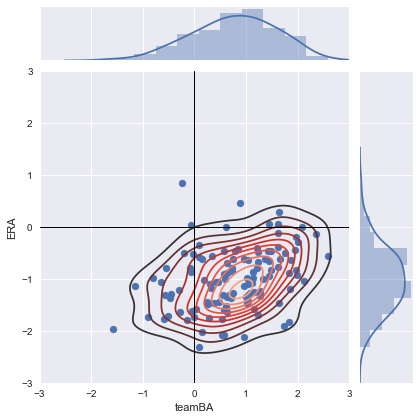

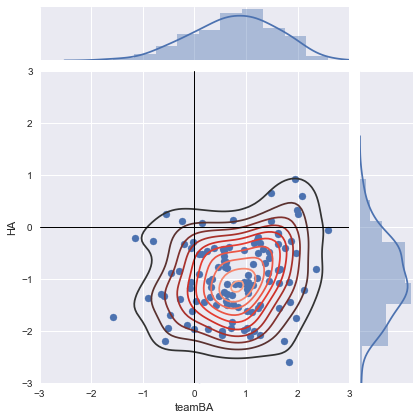

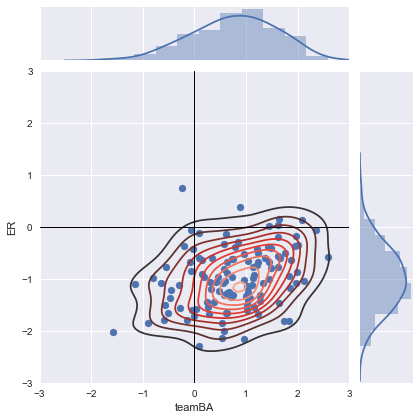

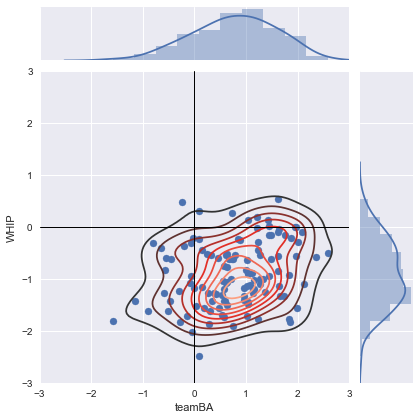

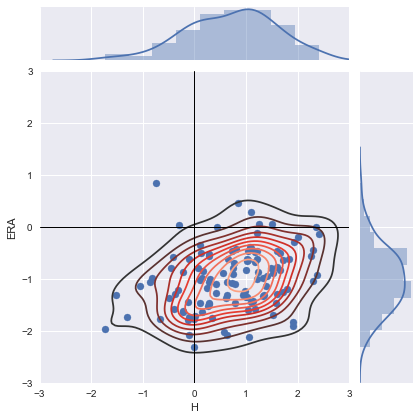

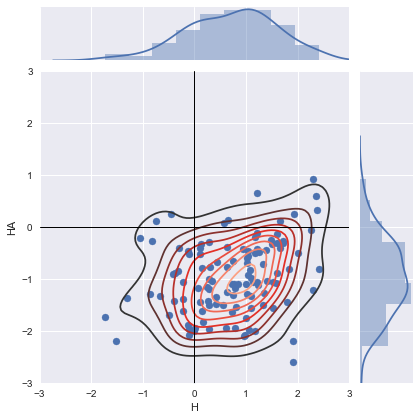

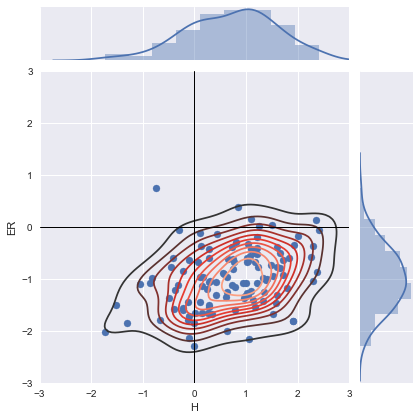

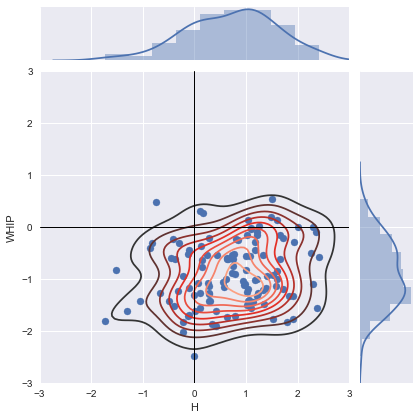

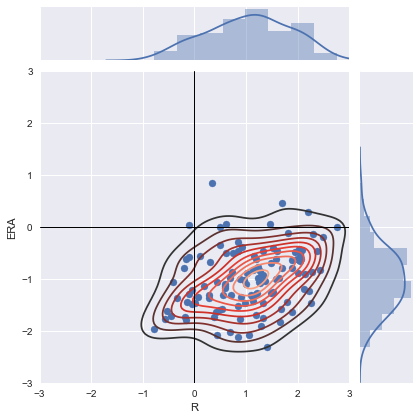

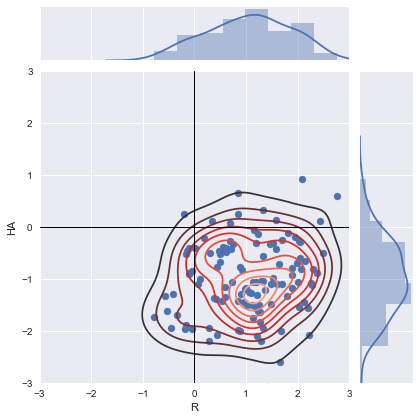

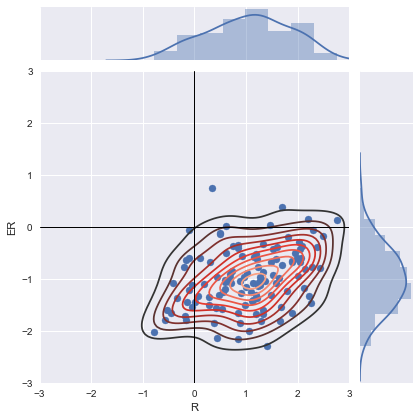

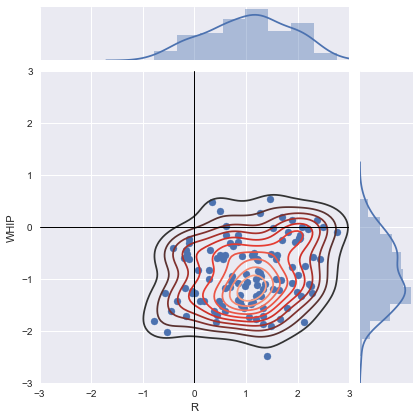

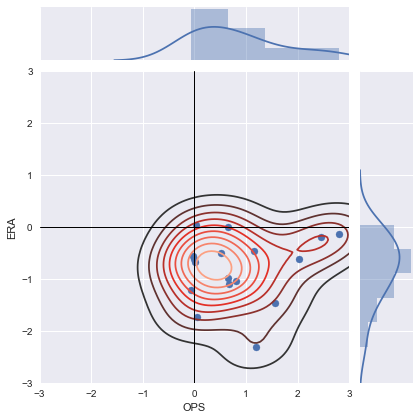

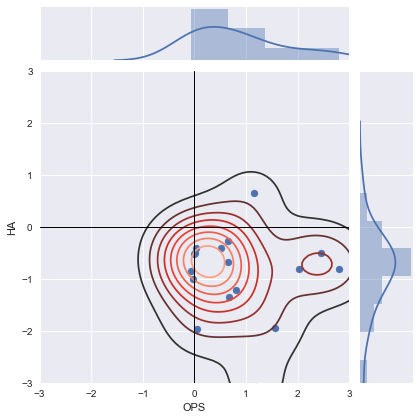

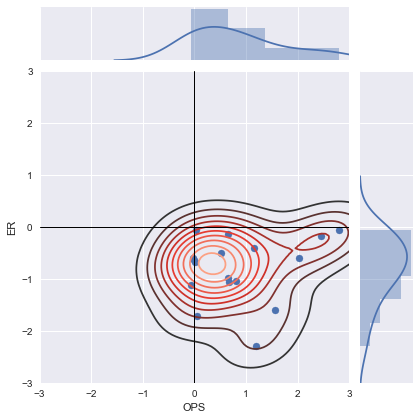

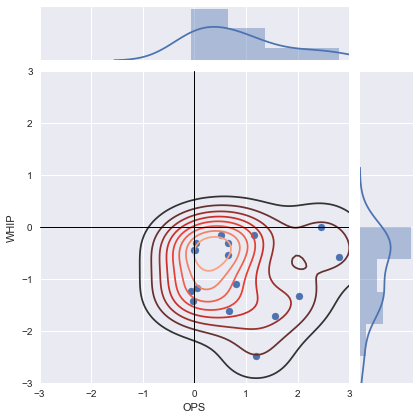

In [210]:
### 1.3 Where WS-winning teams fall in distribution across various metrics ###

stats_offense = ["teamBA", "H", "R", "OPS"]
stats_pitching = ["ERA", "HA", "ER", "WHIP"]

# Visualizing relationships in the stats of interest
for i in range(0, len(stats_offense)):
    for j in range(0, len(stats_pitching)):
        g = sns.JointGrid(x=stats_offense[i], y=stats_pitching[j], data=zscores_wswinners, xlim = (-3,3), ylim = (-3,3))
        g.plot(plt.scatter, sns.distplot)
        g.plot_joint(sns.kdeplot, cmap="Reds_d")
        plt.plot([0, 0], [3, -3], linewidth=1, color="black")
        plt.plot([-3, 3], [0, 0], linewidth=1, color="black")
        plt.show()

So while for the most part, World Series champions tend to be above average on both sides of the ball, there are some interesting and notable outliers. The analysis below picks out a handful of teams that were below average for both metrics in each of the pairwise comparisons made above.

In [211]:
# "Outlier" teams: below average on both dimensions for pairwise comparison of selected metrics.
i_teams_list = []
for i in range(0, len(stats_offense)):
    for j in range(0, len(stats_pitching)):
        i_teams = zscores_wswinners[(zscores_wswinners[stats_offense[i]] < 0) & (zscores_wswinners[stats_pitching[j]] > 0)][[stats_offense[i],stats_pitching[j]]]
        key = stats_offense[i] + " vs. " + stats_pitching[j]
        i_teams_list.append([key,i_teams])

print "These are teams are 'below average' and 'below average' for the pairwise comparison of the given metrics, respectively:\n"        
for comparison in i_teams_list:
    print comparison[0] + ": " + str(comparison[1].index.values)
    


These are teams are 'below average' and 'below average' for the pairwise comparison of the given metrics, respectively:

teamBA vs. ERA: [(1987, 'MIN') (2006, 'SLN')]
teamBA vs. HA: [(1985, 'KCA') (1987, 'MIN')]
teamBA vs. ER: [(1987, 'MIN')]
teamBA vs. WHIP: [(1987, 'MIN')]
H vs. ERA: [(1987, 'MIN') (2006, 'SLN')]
H vs. HA: [(1985, 'KCA') (1987, 'MIN')]
H vs. ER: [(1987, 'MIN')]
H vs. WHIP: [(1987, 'MIN')]
R vs. ERA: [(2006, 'SLN')]
R vs. HA: [(1985, 'KCA')]
R vs. ER: []
R vs. WHIP: []
OPS vs. ERA: []
OPS vs. HA: []
OPS vs. ER: []
OPS vs. WHIP: []


### Conclusion

The analysis above largely supports the notion that, **generally, it isn't a fluke to win the World Series. More often than not, a winning "profile" calls on outperformance from batters and pitchers**, but, as noted above, there are exceptions to this rule of thumb!

The added, Sabermetrics from above (which many argue do a better job of operationally defining the constructs of batting and pitching) make this winning "profile" even clearer: only the 1987 Minnesota Twins won the World Series with subpar pitching (as measured by `WHIP`).  

Interestingly, [this BleacherReport article](http://bleacherreport.com/articles/1379230-the-10-worst-mlb-teams-ever-to-win-the-world-series) lists all of the "outlier" teams identified above as some of the "worst" teams ever to have won the World Series!

## Part II: Age & Salaries of World Series Champions

The second part of my analysis dives deeper into understanding **whether World Series Champions' ages and salaries are, on average, significantly different than their peers**. Because I do not have salary information for seasons before 1985, I will limit the subsequent analysis to 1985 to 2016.

We can precede this analysis by getting a sense of how age and salary correlate with team performance (measured here by number of games won in the regular season, `W`). The limited data set is useful here because by 1985, the regular season for each team consisted of 162 games and has stayed that way since.

### Data Exploration

Much of the wrangling required was already achieved earlier, so we can move to the analysis step for this particular question. First, histogram plots show us the ranges and distribution of the data we're working with:

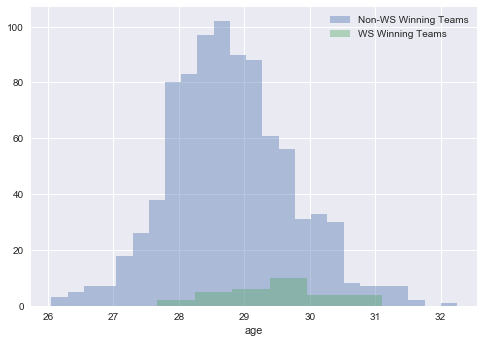

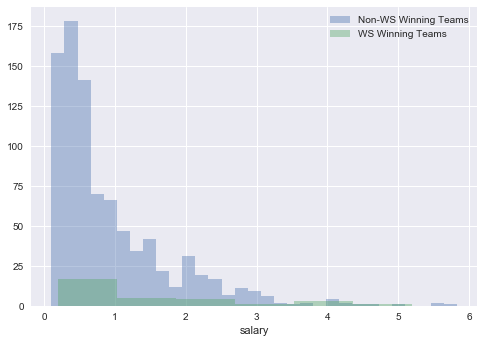

In [212]:
# Select the relevant data
plot_data = team_summary_per_year.loc[1985:].reset_index()

# Scale salary data
plot_data["salary"] = plot_data["salary"] / 1000000

# Divide data into two groups: (1) non-WSW and (2) WSW
non_WSW = plot_data[plot_data["WSWin"] != 1.0]
WSW = plot_data[plot_data["WSWin"] == 1.0]

# Get a sense of the distribution of age and salary over time from 1985 onwards
for variable in ['age','salary']:
    fig, ax = plt.subplots()
    for a in [non_WSW, WSW]:
        if a is non_WSW:
            label = "Non-WS Winning Teams"
        else: 
            label = "WS Winning Teams"
        sns.distplot(a[variable], bins='auto', ax=ax, kde=False, label=label)
        plt.legend()
plt.show()

Immediately, we begin to get the sense that the range and distribution of average ages and salaries for World Series Champions is not wholly like that of non-World Series Champions...but can we infer (via hypothesis testing) that they, on average, differ? This question is answered toward the end of the analysis.

Before that, I also wanted to see if there were any obvious relationships in between salary and/or age and winning (during the regular season):

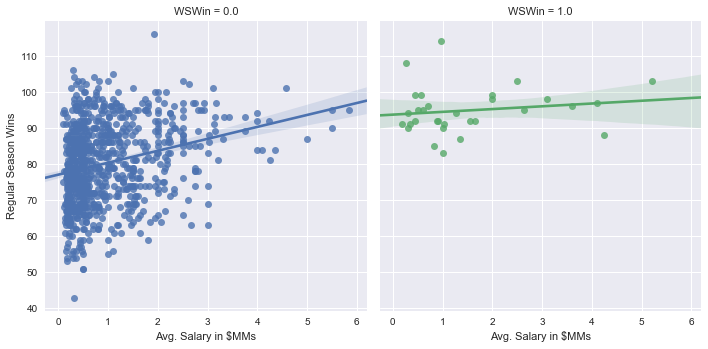

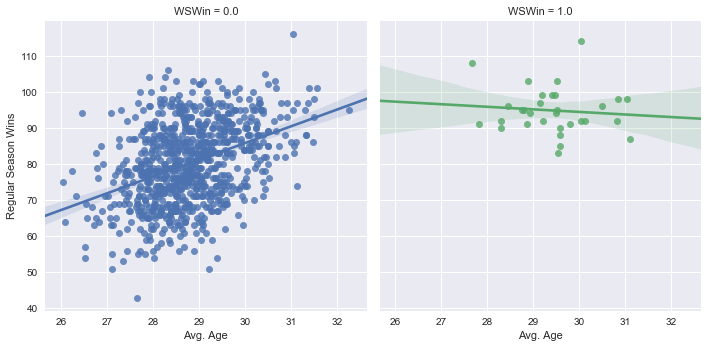

In [213]:
## Plot the regressions of salary and age against regular season wins; compare all teams vs. WS winning teams
ax1 = sns.lmplot(x="salary", y="W", data=plot_data, col="WSWin", hue="WSWin")
ax1.set_xlabels("Avg. Salary in $MMs")
ax1.set_ylabels("Regular Season Wins")
ax2 = sns.lmplot(x="age", y="W", data=plot_data, col="WSWin", hue="WSWin")
ax2.set_xlabels("Avg. Age")
ax2.set_ylabels("Regular Season Wins")

plt.show()

In [214]:
# Correlation between salary, age, and games won for all teams (post-1984)
corr1 = non_WSW[["salary", "age", "W"]].corr()

# Correlation between salary, age, and games won for WS winning teams (post-1984)
corr2 = WSW[["salary", "age", "W"]].corr()

print "All teams (1985+):"
display(corr1)
print "World Series winning teams (1985+):"
display(corr2)

All teams (1985+):


,salary,age,W
salary,1.000000,0.404597,0.276968
age,0.404597,1.000000,0.358491
W,0.276968,0.358491,1.000000


World Series winning teams (1985+):


,salary,age,W
salary,1.000000,0.391010,0.159556
age,0.391010,1.000000,-0.097301
W,0.159556,-0.097301,1.000000


The charts and correlation tables above divide the data by (1) all teams in each season from 1985 onwards and (2) just the World Series winners.

The relationships are generally stronger between age, salary, and regular season wins when considering all of the teams. Among World Series winners, it is very clear that average age of the team does not seem to matter (vis-à-vis wins), whereas generally, it is that case that age is somewhat positively correlated to wins.

Finally, to fully flesh out an answer to the question of whether wages and salaries differ between World Series winners and their peers, a statistical inference can be drawn based on the results of a hypothesis test:

$$H_{0}: \mu_{non-WSW} = \mu_{WSW}$$
$$H_{A}: \mu_{non-WSW} \neq \mu_{WSW}$$

Note: The above hypotheses hold when testing along both `age` and `salary`.

In [215]:
# Conduct t-tests along both 'age' and 'salary' dimensions
for dimension in ['age','salary']:
    print 'For "%s": The t-statistic is %.5f; the p-value is %.5f.' % (dimension, stats.ttest_ind(non_WSW[dimension], WSW[dimension])[0],stats.ttest_ind(non_WSW[dimension], WSW[dimension])[1])

For "age": The t-statistic is -3.73848; the p-value is 0.00020.
For "salary": The t-statistic is -3.61946; the p-value is 0.00031.


### Conclusion

When performing the two-sample, independent t-test above, we were treating the non-World Series winning teams (`non-WSW`) and the World Series winning teams (`WSW`) as samples from notional populations (e.g., all of the non- and World Series winning teams of all time, including the future!). Conditioning on the null hypothesis true, we can say that it very unlikely that we would have sample data like this. 

Therefore, based on a sample of data, for the years 1985 to 2016, **we reject the hypothesis that WS-winning teams are/are not younger, on average, than their peer teams (at the $\alpha = 0.05$ significance level).**